# Traditional Machine learning versus Convolutional Neural Networks
This notebook servers as a proof-of-concept for the research done for the development of the Moodboard Generator project. Within this research, traditional machine learning and cnns will be compared in usefulness for smaller datasets. The dataset that will be used is pictures of Pokemon, that will be seperated into liked and disliked classes.

## Downloading the images and preparing them for use

In order to dived the images, 50 images were chosen for the liked class, and 50 for the disliked. These were picked at random at first, but this made both models about 50% accurate. In order to mitigate the random selection, 50 images were manually chosen per class. This was done by selecting winged Pokemon for the liked folder, and Pokemon without wings for the disliked class. This could make it a more realistic scenario, and ensure that the models have something to go on. Do not execute the next code block.

In [11]:
import os
import random
import shutil

files_list = []

for root, dirs, files in os.walk("./MLvsCNNimages/images"):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
            files_list.append(os.path.join(root, file))

file_count = len(files_list)
print(file_count)

filesToCopyLiked = random.sample(files_list, 50)
filesToCopyDisliked = random.sample(files_list, 50)

destPathLiked = "./MLvsCNNimages/dataset/liked"
destPathDisliked = "./MLvsCNNimages/dataset/disliked"


if not os.path.isdir(destPathLiked):
    os.makedirs(destPathLiked)

if not os.path.isdir(destPathDisliked):
    os.makedirs(destPathDisliked)

for file in filesToCopyLiked:
    shutil.copy(file, destPathLiked)

for file in filesToCopyDisliked:
    shutil.copy(file, destPathDisliked)

809


Now, let's see if everything is in order by seeing how many images are in both folders.

In [13]:
import os

files_list = []
for root, dirs, files in os.walk("./MLvsCNNimages/dataset/disliked"):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
            files_list.append(os.path.join(root, file))

file_count = len(files_list)
print("Disliked images: " + str(file_count))

files_list = []
for root, dirs, files in os.walk("./MLvsCNNimages/dataset/liked"):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
            files_list.append(os.path.join(root, file))

file_count = len(files_list)
print("Liked images: " + str(file_count))

Disliked images: 50
Liked images: 50


Import the images as dataset

In [35]:
import tensorflow as tf

data_dir = "./MLvsCNNimages/dataset"

batch_size = 10
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


class_names = train_ds.class_names
print(class_names)

Found 100 files belonging to 2 classes.
Using 80 files for training.
Found 100 files belonging to 2 classes.
Using 20 files for validation.
['disliked', 'liked']


Inspecting some images

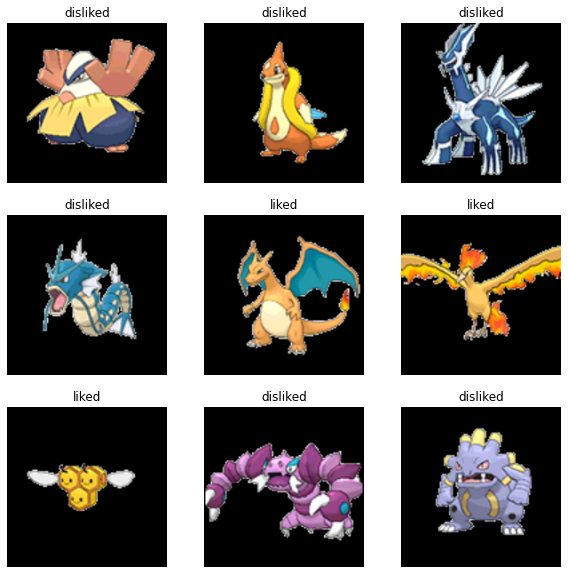

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


Configure the dataset for performance

In [37]:
 AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Traditional Machine learning model

In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds, validation_data=val_ds, epochs=25)

Epoch 1/25
8/8 [==============================] - 3s 168ms/step - loss: 18.1652 - accuracy: 0.5375 - val_loss: 5.7029 - val_accuracy: 0.5500
Epoch 2/25
8/8 [==============================] - 1s 99ms/step - loss: 4.0182 - accuracy: 0.7875 - val_loss: 1.7625 - val_accuracy: 0.8500
Epoch 3/25
8/8 [==============================] - 1s 97ms/step - loss: 3.9640 - accuracy: 0.7500 - val_loss: 8.7427 - val_accuracy: 0.5000
Epoch 4/25
8/8 [==============================] - 1s 112ms/step - loss: 1.5250 - accuracy: 0.8625 - val_loss: 0.3587 - val_accuracy: 0.8500
Epoch 5/25
8/8 [==============================] - 1s 94ms/step - loss: 0.5945 - accuracy: 0.9125 - val_loss: 0.6827 - val_accuracy: 0.9000
Epoch 6/25
8/8 [==============================] - 1s 104ms/step - loss: 0.4220 - accuracy: 0.9750 - val_loss: 3.4172 - val_accuracy: 0.6500
Epoch 7/25
8/8 [==============================] - 1s 107ms/step - loss: 0.4455 - accuracy: 0.9625 - val_loss: 3.6650 - val_accuracy: 0.6500
Epoch 8/25
8/8 [======

Evaluate the accuracy

In [48]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)
print('\nTest accuracy:', str(test_acc * 100) + "%")

2/2 - 0s - loss: 1.2097 - accuracy: 0.9000 - 58ms/epoch - 29ms/step

Test accuracy: 89.99999761581421%


## Convolutional Neural Network

In [49]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names))
])

cnn_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
8/8 [==============================] - 8s 691ms/step - loss: 0.6850 - accuracy: 0.5500 - val_loss: 0.5451 - val_accuracy: 0.8000
Epoch 2/10
8/8 [==============================] - 5s 589ms/step - loss: 0.5008 - accuracy: 0.7750 - val_loss: 0.5553 - val_accuracy: 0.6500
Epoch 3/10
8/8 [==============================] - 4s 526ms/step - loss: 0.3450 - accuracy: 0.8250 - val_loss: 0.4866 - val_accuracy: 0.8500
Epoch 4/10
8/8 [==============================] - 4s 460ms/step - loss: 0.2518 - accuracy: 0.9125 - val_loss: 0.1938 - val_accuracy: 0.9500
Epoch 5/10
8/8 [==============================] - 4s 522ms/step - loss: 0.1132 - accuracy: 0.9625 - val_loss: 0.5170 - val_accuracy: 0.8000
Epoch 6/10
8/8 [==============================] - 4s 516ms/step - loss: 0.0474 - accuracy: 0.9875 - val_loss: 0.4086 - val_accuracy: 0.9000
Epoch 7/10
8/8 [==============================] - 4s 489ms/step - loss: 0.0325 - accuracy: 0.9875 - val_loss: 0.6045 - val_accuracy: 0.8500
Epoch 8/10
8/8 [====

Evaluate the accuracy

In [50]:
test_loss, test_acc = cnn_model.evaluate(val_ds, verbose=2)
print('\nTest accuracy:', str(test_acc * 100) + "%")

2/2 - 0s - loss: 0.6869 - accuracy: 0.8500 - 256ms/epoch - 128ms/step

Test accuracy: 85.00000238418579%


# Results
With random images (3-25 epochs): ML = 50%, CNN = 50%
With picked images (5 epochs): ML = 75%, CNN = 50%
With picked images (10 epochs): ML = 90%, CNN = 80%
With picked images (25 epochs): ML = 90%, CNN = 85%